# ***Çapraz Doğrulama - (Cross Validation)***
# ***& Hiperparametre Ayarlama (Hyperparameter Tuning)***

## ***Titanic***

Bu ödevde, bir önceki derste Titanic verileri ile oluşturduğunuz modelin performansını ölçeceksiniz.

- Modelinizin performansı çapraz doğrulama yaparak ve farklı metrikler kullanarak değerlendirin.
- Hiperparemetre ayarlaması yaparak en uygun parametrelere sahip modeli belirleyin.
---

In [169]:
import pandas as pd
import numpy as np
# grafiksel araclar
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
sns.set(style="whitegrid")
# logistic regresyon icin
from sklearn.linear_model import LogisticRegression
# lineer regresyon icin
from sklearn.linear_model import LinearRegression
# egitim verisini ayirmak icin
from sklearn.model_selection import train_test_split
# hata matrisi olusturmak icin
from sklearn.metrics import confusion_matrix
# tahmin performansi icin
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
# performans metrikleri icin
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# cross validation icin
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate, cross_val_score
# hiperparametre tuning icin
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# lineer regresyonda regularizasyon icin
from sklearn.linear_model import Ridge
# orneklem artirma icin
from imblearn.over_sampling import ADASYN


# uyarilari dikkate alma
import warnings
warnings.filterwarnings('ignore')

# pandas varsayilan olarak cok sayida sutun veya satir varsa tumunu gostermez
# bu nedenle 100 sutun ve satir gostermesi icin
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# virgulden sonra belirli sayida basamak gosterimi icin 
pd.options.display.float_format = '{:,.3f}'.format
# aciklama sutunun tam cikmasi icin
pd.options.display.max_colwidth = 100

# font tanimlamalari
title_font = {'family': 'times new roman', 'color': 'darkred', 
              'weight': 'bold', 'size': 14}
axis_font  = {'family': 'times new roman', 'color': 'darkred', 
              'weight': 'bold', 'size': 14}

# veri setini dataframe icerisine yukle
titanic = pd.read_csv('data/train.csv')

- Fonksiyon tanimlamalari.

In [170]:
# performance degerlerini tutacak df
performance_df = pd.DataFrame( columns=['model', 'type', 'accuracy', 
                                        'error_rate', 'precision', 'sensitivity',
                                        'specifity', 'f1score', 'support_ratio'])

# dogruluk degerlerini df kaydeden fonksiyon
def save_performance(model, y_train, y_train_pred, y_test, y_test_pred, train=False):
    global performance_df
    # eger model varsa tekrar kaydetme
    if (performance_df.model==model).any():
        return None
    # train icin de performans degerlerini tutsun istiyorsak train=True parametresi kullanilir
    if train==True:
        # hata matrisi degerleri 
        confusion_matrix_train = confusion_matrix(y_train, y_train_pred,)
        tn = confusion_matrix_train[0][0]
        tp = confusion_matrix_train[1][1]
        fp = confusion_matrix_train[0][1]
        fn = confusion_matrix_train[1][0]
        # sadece specifity icin hata matrisi mutlaka gerekiyor 
        # diger metrikler icin hazir fonksiyonlar mevcut
        # support degeri y_train ortalamasi ile hesaplandi, 1 olan sinifin ort
        performance_df = performance_df.append({'model': model, 
                                                'type': 'train',
                                                'accuracy':  accuracy_score(y_train, y_train_pred), 
                                               'error_rate': 1 - accuracy_score(y_train, y_train_pred), 
                                               'precision': precision_score(y_train, y_train_pred),
                                               'sensitivity': recall_score(y_train, y_train_pred),
                                               'specifity': (tn)/(tn + fp),
                                               'f1score': f1_score(y_train, y_train_pred),
                                               'support_ratio': y_train.mean()},
                                               ignore_index=True)
    # hata matrisi degerleri
    confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
    tn = confusion_matrix_test[0][0]
    tp = confusion_matrix_test[1][1]
    fp = confusion_matrix_test[0][1]
    fn = confusion_matrix_test[1][0]
    # metrikler hata matrisinden hesaplandi
    performance_df = performance_df.append({'model': model, 
                                            'type': 'test',
                                            'accuracy': (tn + tp)/(fn + fp + tn + tp), 
                                           'error_rate': (1 - (tn + tp)/(fn + fp + tn + tp)), 
                                           'precision': (tp)/(fp + tp),
                                           'sensitivity': (tp)/(tp + fn),
                                           'specifity': (tn)/(tn + fp),
                                           'f1score': f1_score(y_test, y_test_pred),
                                           'support_ratio': y_test.mean()},
                                           ignore_index=True)
    return None

# modeli test eden fonksiyon
# model adi, X, Y, ve model nesnesini parametre olarak alir
def test_model(model, X, Y, lrm, train=False):
    # egitim ve test veri kumelerine ayirma
    X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.20, random_state=111)
    # modeli egit
    lrm.fit(X_train, Y_train)
    # tahmin yap
    Y_train_pred = lrm.predict(X_train)
    Y_test_pred = lrm.predict(X_test)
    # performans degerlerini kaydet
    save_performance(model, Y_train, Y_train_pred, Y_test, Y_test_pred, train=False)
    #save_performance(8, 'ADASYN egitim', confusion_matrix_train, Y_train, Y_train_pred)
    display(performance_df)
    return None

In [171]:
display(performance_df)

,model,type,accuracy,error_rate,precision,sensitivity,specifity,f1score,support_ratio


### ***Veri Kesfi***
- Veri setini inceleme.

In [172]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- Cabin, Ticket ve Name degiskenleri numerik olmadigindan ve burada ihtiyacimiz olmadigindan cikarabiliriz.

In [173]:
titanic = titanic.drop(['Cabin','Ticket', 'Name'], axis=1)
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked'],
      dtype='object')

In [174]:
titanic['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

- Embarked 3 farkli deger almis, eksik veriler en sik karsilasilan degerle doldurulabilir.

In [175]:
titanic['Embarked'].fillna('S', inplace=True)

- Son olarak yas degeri de ortalama deger ile dolduruldu.

In [176]:
titanic['Age'].fillna(np.floor(titanic['Age'].mean()), inplace=True)

In [177]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


***Cinsiyet ve Liman bilgisi encode edilerek dahil edildi***

In [178]:
# get_dummies metodu ile encode edilir
titanic = pd.concat([titanic, pd.get_dummies(titanic.Sex, 
                                             drop_first=True)], axis=1)
titanic = pd.concat([titanic, pd.get_dummies(titanic.Embarked, 
                                             drop_first=True, prefix='Embarked')], axis=1)
# encode edilen sutunlar drop edilir
titanic.drop(['Sex', 'Embarked'], axis=1, inplace=True)

In [179]:
titanic.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Embarked_Q,Embarked_S
0,1,0,3,22.000,1,0,7.250,1,0,1
1,2,1,1,38.000,1,0,71.283,0,0,0
2,3,1,3,26.000,0,0,7.925,0,0,1
3,4,1,1,35.000,1,0,53.100,0,0,1
4,5,0,3,35.000,0,0,8.050,1,0,1


### ***1. Model: Butun numerik degiskenler***

- Hedef (bagimli) degisken : Survived
- Aciklayici (bagimsiz) degiskenler : Diger degiskenler (Survived ve PassengerId haric)

In [180]:
# hedef ve aciklayici degiskenler
Y = titanic['Survived']
# aciklayici degiskenlerden hedef degisken ve id degiskeni ayrilir
X = titanic.iloc[:,2:]

test_model('numerik degiskenler', X, Y, LogisticRegression())

,model,type,accuracy,error_rate,precision,sensitivity,specifity,f1score,support_ratio
0,numerik degiskenler,test,0.777,0.223,0.703,0.682,0.832,0.692,0.369


---
### ***Capraz Dogrulama - Cross Validation***

***KFold ile capraz dogrulama***
- ```KFold``` metodu veri kumemizi istedigimiz sayida bolumlere ayirarak her bir bolumun indis degerlerini verir. Her bir bolum icin dongu ile model olusturarak bu indis degerlerini  kullanir ve istedigimiz skor degerlerini hesaplar, kaydeder ve ortalamasini hesaplariz. Buna capraz dogrulama denir.

In [181]:
# capraz dogrulama icin bolumlendirme yapacak
# kfold nesnesi olustur
kf = KFold(n_splits=5, shuffle=True, random_state=1111)

# logistic regression nesnesi olustur
log_reg = LogisticRegression()
# veri kumesi farkli katmanlara bolundu
# generator dondurur ve bunu dongu ile kullanabiliriz
folds = kf.split(X)
# skor degerlerini tutacak liste
scores_list = []
for i, (train_index, test_index) in enumerate(folds):
    # indexlere erisim .loc ile olmali yoksa indexleri sutunlarda arar
    X_train, Y_train = X.loc[train_index], Y.loc[train_index]
    X_test, Y_test = X.loc[test_index], Y.loc[test_index]
    # modeli aldigimiz egitim degerleriyle olustur
    log_reg.fit(X_train, Y_train)
    # tahmin yap
    Y_test_pred = log_reg.predict(X_test)
    # istedigin skoru hesapla
    f1score = f1_score(Y_test, Y_test_pred)  
    # skoru sonra ortalama almak icin kaydet
    scores_list.append(f1score)
    print("{}.fold f1 score: {:.3f}".format(i+1, f1score))
    print("-"*30)
    
# skor ortalamasi
print("f1 score mean: {:.2f}".format(np.mean(scores_list)))

1.fold f1 score: 0.792
------------------------------
2.fold f1 score: 0.729
------------------------------
3.fold f1 score: 0.697
------------------------------
4.fold f1 score: 0.737
------------------------------
5.fold f1 score: 0.655
------------------------------
f1 score mean: 0.72


***cross_validate ile capraz dogrulama***

- ```cross_validate``` ile ```KFold``` metoduna nazaran daha hizli sekilde skor degerlerimize ulasabiliriz. ```KFold``` ile yaptigimiz manuel  adimlari ```cross_validate``` kendi icinde otomatik yapar.
- ```cross_validate, return_train_score=True``` parametresi ile test skorlari yaninda train skorlarini istedigimiz turden (accuracy, precision vb.) skor degerleriyle hesaplar. Ayrica kendimiz de skor metodu olusturup cagirabiliriz.

In [182]:
# regresyon modeli nesnesi olustur
lrm = LogisticRegression()
# hesaplamak istedigimiz skor degerlerini scoring ile belirtiyoruz
# varsayilan olarak modelin .score parametresi ile skor hesaplar
# logistic regresyonda .score degeri accuracy, lineer regresyonda ise rsquare
# cross_validate return_train_score=True parametresi ile train skorlarini de hesaplar
# estimator ile model nesnesini, cv parametresi ile bolum sayisini belirtiriz, 
cv = cross_validate(estimator=lrm,
                    X=X,
                    y=Y,
                    cv=10,
                    scoring = ['accuracy', 'precision', 'r2'],
                    return_train_score=True)
print('Accuracy Scores Mean     : ', cv['test_accuracy'].mean(), sep = '\n')
print("-"*30)
print('Precision Scores Mean    : ', cv['test_precision'].mean(), sep = '\n')
print("-"*30)
print('Rsquare Scores Mean      : ', cv['test_r2'].mean(), sep = '\n')
print("-"*30)
print('Accuracy Scores Mean     : ', cv['train_accuracy'].mean(), sep = '\n')
print("-"*30)
print('Precision Scores Mean    : ', cv['train_precision'].mean(), sep = '\n')
print("-"*30)
print('Rsquare Scores Mean      : ', cv['train_r2'].mean(), sep = '\n')
print("-"*30)


Accuracy Scores Mean     : 
0.7912484394506867
------------------------------
Precision Scores Mean    : 
0.7421793771937722
------------------------------
Rsquare Scores Mean      : 
0.11711145064086237
------------------------------
Accuracy Scores Mean     : 
0.8024690147290947
------------------------------
Precision Scores Mean    : 
0.7613291695700382
------------------------------
Rsquare Scores Mean      : 
0.16479263198275707
------------------------------


- ```cross_val_score, cross_validate``` metodunun daha az kabiliyetli olanidir. Soyle ki, tek bir scoring parametresi ile model skorlama yapar liste halinde birden fazla parametre almaz.

- ```cross_val_score, cross_validate``` modelin performans skorlarini bize verir. Her bir fold icin model tahminlerine ulaşmak istersek ```cross_val_predict``` fonksiyonunu kullanabilriz.

- Her uc metod da ```sklearn.model_selection``` kutuphanesindedir.

---
### ***Hiperparametre Ayarlama - Hyperparameter Tuning***

- Modelin en iyi performans veren parametre ayarlamalarini belirli algoritmalarla arayan metodlardir. En cok kullanilanlari ***GridSearch ve RandomSearch*** metodlaridir.

- Kullancagimiz modelin parametrelerini inceleyip, hangi parametrelerin optimum degerlerini arayacagimizi bu metodlara bildirir ve modelimizden maksimum verimi almaya calisiriz.

#### ***Grid Search***

- Grid search yöntemi geleneksel hiperparametre ayarlama yöntemidir. Ayarlanmak istenen parametre değerleri bir liste ile belirlenir ve tüm ihtimaller denenerek en uygun parametrelere ulaşılır. 

- Logistic regression modulunde varsayilan solver olarak gelen ```lbfgs```  penalty parametresi olarak ```l1``` desteklemez. Bu nedenle ```l1 ve l2``` parametrelerini destekleyen ```liblinear``` solver kullanilabilir. Konu icin [scikit-learn LogisticRegression dokumantasyonu](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)ndan solver bolumu ya da [stackoverflow](https://stackoverflow.com/questions/60868629/valueerror-solver-lbfgs-supports-only-l2-or-none-penalties-got-l1-penalty) incelenebilir. 

In [132]:
# logistic regression nesnesi olustur l1 ve l2 penalty destekleyen solver onemli
log_reg = LogisticRegression(solver='liblinear')
# logistic regression hangi parametreleri aliyor incele
print(log_reg.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [133]:
parameters = {"C": [10 ** x for x in range (-7, 7, 1)],
                "penalty": ['l1','l2']
                }

grid_cv = GridSearchCV(estimator=log_reg,
                       param_grid = parameters,
                       cv = 10,
                       scoring='f1'
                      )
grid_cv.fit(X, Y)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                               10, 100, 1000, 10000, 100000, 1000000],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

- ```GridSearchCV``` fonksiyonu çapraz doğrulama yaparak liste olarak belirlediğimiz parametreleri belirtiğimiz modelde deneyerek sonuçlar elde etti. Modelimiz için belirlenen en uygun parametre değerlerini ```best_params_``` fonksiyonu ile görebiliriz.

In [134]:
print("En iyi parametreler : ", grid_cv.best_params_)
print("En iyi skor         : ", grid_cv.best_score_)

En iyi parametreler :  {'C': 1000, 'penalty': 'l2'}
En iyi skor         :  0.7233213087104879


- Tüm sonuçları ```cv_results_``` ile görebilir ve bu değerleri bir veri çerçevesine atabiliriz.

In [135]:
results = grid_cv.cv_results_
df = pd.DataFrame(results)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007,0.001,0.004,0.000,0.000,l1,"{'C': 1e-07, 'penalty': 'l1'}",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,25
1,0.006,0.000,0.003,0.000,0.000,l2,"{'C': 1e-07, 'penalty': 'l2'}",0.373,0.393,0.453,0.596,0.444,0.500,0.417,0.500,0.538,0.415,0.463,0.066,17
2,0.005,0.001,0.003,0.001,0.000,l1,"{'C': 1e-06, 'penalty': 'l1'}",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,25
3,0.005,0.001,0.003,0.000,0.000,l2,"{'C': 1e-06, 'penalty': 'l2'}",0.316,0.377,0.453,0.596,0.423,0.440,0.417,0.453,0.549,0.360,0.438,0.080,19
4,0.005,0.000,0.003,0.000,0.000,l1,"{'C': 1e-05, 'penalty': 'l1'}",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,25


- Her bir çapraz doğrulama parçası için performans değerlerini, hesaplama sürelerini ortalaması ve standart sapması gibi bir çok değeri görebiliyoruz. Şimdilik parametreler ve ortalama test skoru ihtiyacımızı görecektir.

In [136]:
df = df[['param_penalty','param_C', 'mean_test_score']]
df = df.sort_values(by='mean_test_score', ascending = False)
df

,param_penalty,param_C,mean_test_score
27,l2,1000000,0.723
25,l2,100000,0.723
23,l2,10000,0.723
21,l2,1000,0.723
16,l1,10,0.721
26,l1,1000000,0.721
24,l1,100000,0.721
22,l1,10000,0.721
20,l1,1000,0.721
19,l2,100,0.721


- Parametre kombinasyonlarini grafik üzerinde inceleyelim.

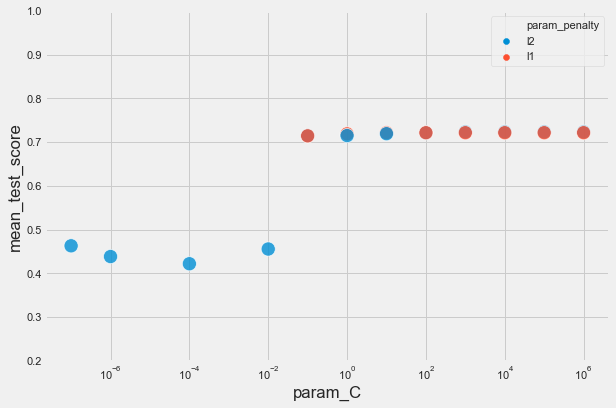

In [137]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9,6))
sns.scatterplot(x='param_C', y='mean_test_score', alpha=0.8,
                hue='param_penalty', data=df[0:20], s=200)
plt.xscale('log')
plt.ylim((0.2,1))
plt.show()

- Plotly grafigi.

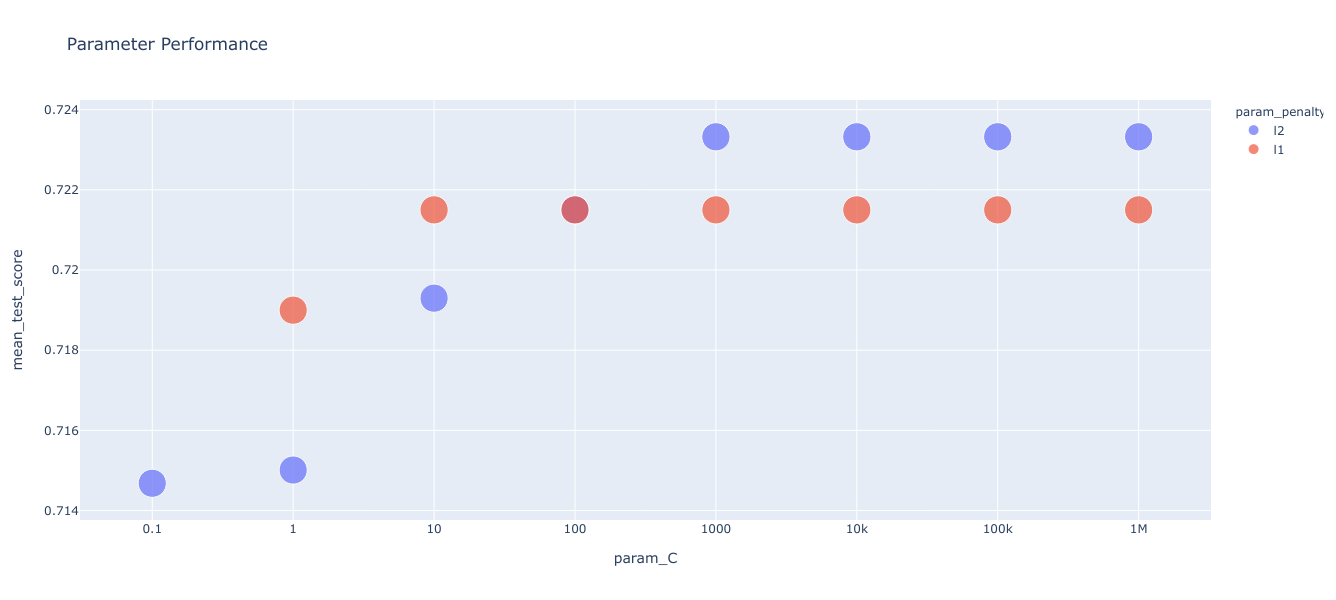

In [138]:
fig = px.scatter(df[0:15], x='param_C', y='mean_test_score', size='mean_test_score',
                 color='param_penalty', title='Parameter Performance', width=1200, height=600)
fig.update_layout(xaxis_type="log")
fig.show()

- ```GridSearchCVve RandomSearchCV``` de kullanilabilecek gecerli ```scoring``` parametreleri ```SCORERS``` listesindedir. 

In [139]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

#### ***Random Search***

- Randomize Search yöntemi Grid Search yöntemine çok benzemektedir. Grid Search yönteminde parametrelerin alabileceği tüm kombinasyonlar denenmekte iken Randomize Search yönteminde istenen sayıdaki rastgele kombinasyonlar denenmektedir. Bu sayede Randomize Search yönteminde parametre olarak liste yerine bir değer aralığı da kullanılabilmektedir.

In [140]:
parameters = {"C": [10 ** x for x in range (-7, 7, 1)],
                "penalty": ['l1', 'l2']
                }

- ```GridSearchCV``` metodundan farklı olarak, kaç farklı kombinasyon deneneceğini ```n_iter``` parametresi ile belirlememiz gerekmektedir.

In [141]:
rs_cv = RandomizedSearchCV(estimator=log_reg,
                           param_distributions = parameters,
                           cv = 10,
                           n_iter = 10,
                           random_state = 111,
                           scoring = 'f1'
                      )
rs_cv.fit(X, Y)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='liblinear', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': [1e-07, 1e-06, 1e-05, 0.0001,
                                              0.001, 0.01, 0.1, 1, 10, 100,
                                              1000, 10000, 100000, 1000000],
                                        'penalty

In [142]:
print("En iyi parametreler        : ", rs_cv.best_params_)
print("Tüm skor değerleri   : ", rs_cv.cv_results_['mean_test_score'])
print("En iyi skor değeri   : ", rs_cv.best_score_)

En iyi parametreler        :  {'penalty': 'l2', 'C': 1000}
Tüm skor değerleri   :  [0.43840628 0.45562502 0.7146807  0.71925893 0.71899761 0.
 0.72332131 0.71501095 0.         0.41741632]
En iyi skor değeri   :  0.7233213087104879


In [143]:
results_rs = rs_cv.cv_results_
df_rs = pd.DataFrame(results_rs)
df_rs.shape

(10, 20)

In [144]:
df_rs = df_rs[['param_penalty','param_C', 'mean_test_score']]
df_rs = df_rs.sort_values(by='mean_test_score', ascending = False)
df_rs

,param_penalty,param_C,mean_test_score
6,l2,1000,0.723
3,l1,10,0.719
4,l1,1,0.719
7,l2,1,0.715
2,l2,0.100,0.715
1,l2,0.010,0.456
0,l2,0.000,0.438
9,l2,0.000,0.417
5,l1,0.000,0.000
8,l1,0.000,0.000


- Rastgele 10 kombinasyon ile yukarıdaki değerleri elde ettik.

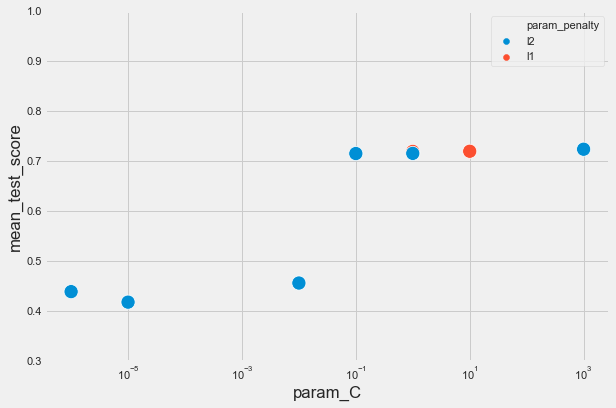

In [145]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9,6))
sns.scatterplot(x='param_C', y='mean_test_score', hue='param_penalty', data=df_rs, s=200)
plt.xscale('log')
plt.ylim((0.3,1))
plt.show()

- Plotly grafigi.

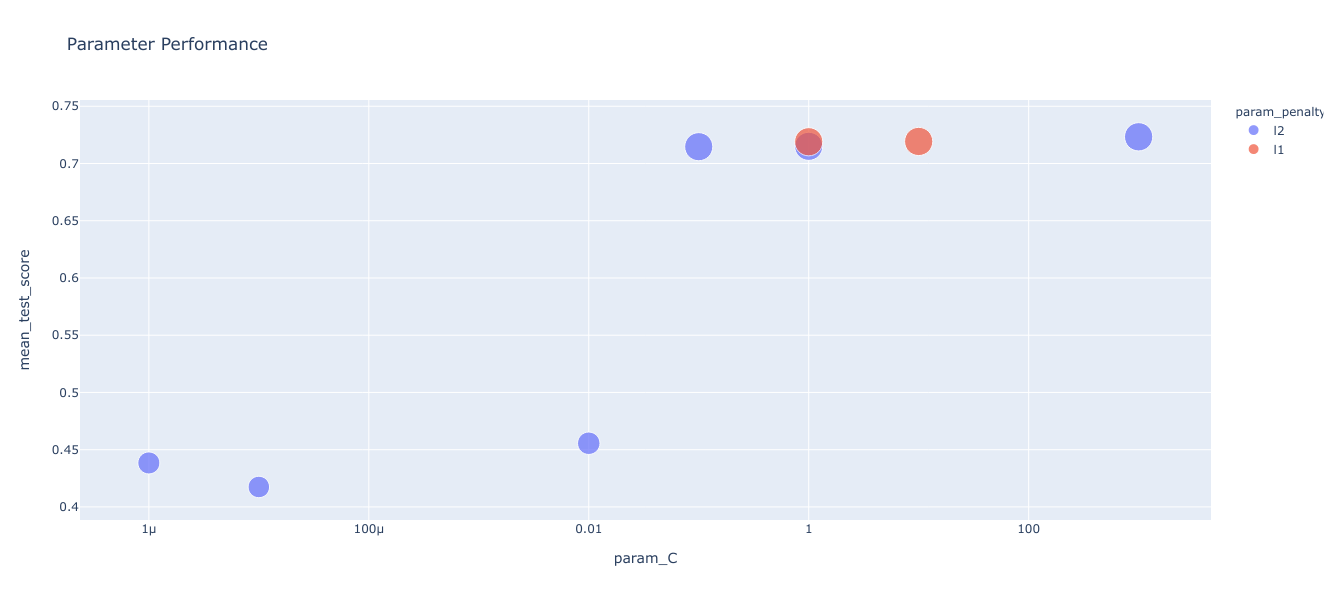

In [146]:
fig = px.scatter(df_rs[0:8], x='param_C', y='mean_test_score', size='mean_test_score',
                 color='param_penalty', title='Parameter Performance', width=1200, height=600)
fig.update_layout(xaxis_type="log")
fig.show()

- Grid search ve random search sonucunda cikan parametreleri modelimizde kullanirsak.

In [147]:
print("Grid search en iyi parametreler       : ", grid_cv.best_params_)
print("Grid search en iyi skor değeri        : ", grid_cv.best_score_)
print("Random search en iyi parametreler     : ", rs_cv.best_params_)
print("Random search en iyi skor değeri      : ", rs_cv.best_score_)

Grid search en iyi parametreler       :  {'C': 1000, 'penalty': 'l2'}
Grid search en iyi skor değeri        :  0.7233213087104879
Random search en iyi parametreler     :  {'penalty': 'l2', 'C': 1000}
Random search en iyi skor değeri      :  0.7233213087104879


In [148]:
test_model('numerik degiskenler_param_grid', X, Y, 
           LogisticRegression(solver='liblinear', C=1000, penalty='l2'))

,model,type,accuracy,error_rate,precision,sensitivity,specifity,f1score,support_ratio
0,numerik degiskenler,test,0.777,0.223,0.703,0.682,0.832,0.692,0.369
1,numerik degiskenler_param_grid,test,0.777,0.223,0.697,0.697,0.823,0.697,0.369


In [149]:
test_model('numerik degiskenler_param_random', X, Y, 
           LogisticRegression(solver='liblinear', C=1000, penalty='l2'))

,model,type,accuracy,error_rate,precision,sensitivity,specifity,f1score,support_ratio
0,numerik degiskenler,test,0.777,0.223,0.703,0.682,0.832,0.692,0.369
1,numerik degiskenler_param_grid,test,0.777,0.223,0.697,0.697,0.823,0.697,0.369
2,numerik degiskenler_param_random,test,0.777,0.223,0.697,0.697,0.823,0.697,0.369


---
### ***Resampling***
#### ***ADASYN ile Orneklem Artirma***

In [150]:
# hedef ve aciklayici degiskenler
Y = titanic.Survived
X = titanic.iloc[:,2:]

# ADASYN dengesizlik varsa sample uretir
ad = ADASYN()
X_adasyn, Y_adasyn = ad.fit_sample(X, Y)

test_model('ADASYN_param', X_adasyn, Y_adasyn, 
           LogisticRegression(solver='liblinear', C=1000, penalty='l2'))

,model,type,accuracy,error_rate,precision,sensitivity,specifity,f1score,support_ratio
0,numerik degiskenler,test,0.777,0.223,0.703,0.682,0.832,0.692,0.369
1,numerik degiskenler_param_grid,test,0.777,0.223,0.697,0.697,0.823,0.697,0.369
2,numerik degiskenler_param_random,test,0.777,0.223,0.697,0.697,0.823,0.697,0.369
3,ADASYN_param,test,0.831,0.169,0.851,0.822,0.841,0.836,0.524


---
### ***3. Model: Yasi tahminle doldurarak***
- Yas degiskenindeki eksik degerler lineer regresyon yontemiyle doldurulacaktir.
- Regresyon yonteminde cross validation ve grid search gibi yontemler uygulanacaktir.
- Lineer regresyonda Ridge, Lasso ve ElasticNet gidi modeller hiperparametre ayarlamalarina izin verdiginden burada Ridge kullanacagiz.

- Onceki df den eksik degerli yas sutununu tekrar alalim

In [151]:
titanic.head(20)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Embarked_Q,Embarked_S
0,1,0,3,22.000,1,0,7.250,1,0,1
1,2,1,1,38.000,1,0,71.283,0,0,0
2,3,1,3,26.000,0,0,7.925,0,0,1
3,4,1,1,35.000,1,0,53.100,0,0,1
4,5,0,3,35.000,0,0,8.050,1,0,1
5,6,0,3,29.000,0,0,8.458,1,1,0
6,7,0,1,54.000,0,0,51.862,1,0,1
7,8,0,3,2.000,3,1,21.075,1,0,1
8,9,1,3,27.000,0,2,11.133,0,0,1
9,10,1,2,14.000,1,0,30.071,0,0,0


In [152]:
age = pd.read_csv('data/train.csv')

age.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S
5,6,0,3,"Moran, Mr. James",male,nan,0,0,330877,8.458,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000,0,0,17463,51.862,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000,3,1,349909,21.075,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000,0,2,347742,11.133,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000,1,0,237736,30.071,NaN,C


In [153]:
# df ler sirali degilse sort edebiliriz
#age = age.sort_values(by='PassengerId').head()
#titanic = titanic.sort_values(by='PassengerId')

titanic['Age'] = age['Age']
titanic.head(20)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Embarked_Q,Embarked_S
0,1,0,3,22.000,1,0,7.250,1,0,1
1,2,1,1,38.000,1,0,71.283,0,0,0
2,3,1,3,26.000,0,0,7.925,0,0,1
3,4,1,1,35.000,1,0,53.100,0,0,1
4,5,0,3,35.000,0,0,8.050,1,0,1
5,6,0,3,nan,0,0,8.458,1,1,0
6,7,0,1,54.000,0,0,51.862,1,0,1
7,8,0,3,2.000,3,1,21.075,1,0,1
8,9,1,3,27.000,0,2,11.133,0,0,1
9,10,1,2,14.000,1,0,30.071,0,0,0


In [154]:
titanic['Age'].isnull().mean()

0.19865319865319866

- Yas bilgisinin null orani da 80 e 20 kuaralina uymaktadir.

- Yas degeri olan ve olmayan data ikiye ayrildi

In [155]:
titanic_no_age = titanic[titanic['Age'].isnull()]

In [156]:
titanic_w_age = titanic[titanic['Age'].notnull()]

- Hedef (bagimli) degisken : Yas
- Aciklayici (bagimsiz) degiskenler : Diger tum numerik degiskenler

In [157]:
titanic_w_age.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Embarked_Q,Embarked_S
0,1,0,3,22.000,1,0,7.250,1,0,1
1,2,1,1,38.000,1,0,71.283,0,0,0
2,3,1,3,26.000,0,0,7.925,0,0,1
3,4,1,1,35.000,1,0,53.100,0,0,1
4,5,0,3,35.000,0,0,8.050,1,0,1


In [158]:
# hedef ve aciklayici degiskenler
Y = titanic_w_age['Age']
X = titanic_w_age.drop(['Age','PassengerId'], axis=1)

# egitim ve test veri kumelerine ayirma
X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.20, random_state=111)

# log reg model nesnesi olustur
lrm = LinearRegression()
# modeli egit
lrm.fit(X_train, Y_train)

# rsquare skorlari
train_rsquare = lrm.score(X_train, Y_train)
test_rsquare = lrm.score(X_test, Y_test)

# test verisi ile tahmin
Y_test_pred = lrm.predict(X_test)
# egitim verisi ile tahmin
Y_train_pred = lrm.predict(X_train)

print('Egitim rsquare degeri: ', train_rsquare, 
      'Test rsquare degeri:', test_rsquare, 
      'RMSE degeri: ', rmse(Y_test, Y_test_pred) , sep='\n')


Egitim rsquare degeri: 
0.28042114915051497
Test rsquare degeri:
0.2467928881451541
RMSE degeri: 
13.066275300846298


- Bir kez daha model olusturuyoruz. Bu defa daha cok veriyle doldurmak icin split etmeden olusturduk. Yas degeri olmayan verilerle de tahmin yaparak yas degerini dolduracagiz.

In [159]:
Y = titanic_w_age['Age']
X = titanic_w_age.drop(['Age','PassengerId'], axis=1)

# model nesnesi olustur
lrm = LinearRegression()
# modeli egit
lrm.fit(X, Y)

# tahmini yas degeri olmayan data uzerinde yaptik
# yas degeri eksi ya da ondalikli olmasin 
titanic_no_age['Age'] = np.floor(np.abs(lrm.predict(titanic_no_age.drop(['Age','PassengerId'], axis=1))))

In [160]:
# iki veri kumesini birlestir
titanic = pd.concat([titanic_no_age, titanic_w_age])
# sirala
titanic = titanic.sort_values(by='PassengerId')

In [161]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   male         891 non-null    uint8  
 8   Embarked_Q   891 non-null    uint8  
 9   Embarked_S   891 non-null    uint8  
dtypes: float64(2), int64(5), uint8(3)
memory usage: 58.3 KB


- Nihai logistic regression modelini olusturalim.

In [162]:
# hedef ve aciklayici degiskenler
Y = titanic.Survived
X = titanic.iloc[:,2:]

# modeli olustur ve test et varsayilan parametrelerle
test_model('yas tahminiyle varsayilan', X, Y, 
           LogisticRegression())

,model,type,accuracy,error_rate,precision,sensitivity,specifity,f1score,support_ratio
0,numerik degiskenler,test,0.777,0.223,0.703,0.682,0.832,0.692,0.369
1,numerik degiskenler_param_grid,test,0.777,0.223,0.697,0.697,0.823,0.697,0.369
2,numerik degiskenler_param_random,test,0.777,0.223,0.697,0.697,0.823,0.697,0.369
3,ADASYN_param,test,0.831,0.169,0.851,0.822,0.841,0.836,0.524
4,yas tahminiyle varsayilan,test,0.799,0.201,0.734,0.712,0.850,0.723,0.369


In [163]:
# logistic regression nesnesi olustur l1 ve l2 penalty destekleyen solver onemli
log_reg = LogisticRegression(solver='liblinear')

parameters = {"C": [10 ** x for x in range (-7, 7, 1)],
                "penalty": ['l1','l2']
                }

grid_cv = GridSearchCV(estimator=log_reg,
                       param_grid = parameters,
                       cv = 10,
                       scoring='f1'
                      )
grid_cv.fit(X, Y)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                               10, 100, 1000, 10000, 100000, 1000000],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [164]:
print("Grid search en iyi parametreler       : ", grid_cv.best_params_)
print("Grid search en iyi skor değeri        : ", grid_cv.best_score_)

Grid search en iyi parametreler       :  {'C': 10, 'penalty': 'l1'}
Grid search en iyi skor değeri        :  0.7419230076141105


In [165]:
test_model('yas tahminiyle param_grid', X, Y, 
           LogisticRegression(solver='liblinear', C=10, penalty='l1'))

,model,type,accuracy,error_rate,precision,sensitivity,specifity,f1score,support_ratio
0,numerik degiskenler,test,0.777,0.223,0.703,0.682,0.832,0.692,0.369
1,numerik degiskenler_param_grid,test,0.777,0.223,0.697,0.697,0.823,0.697,0.369
2,numerik degiskenler_param_random,test,0.777,0.223,0.697,0.697,0.823,0.697,0.369
3,ADASYN_param,test,0.831,0.169,0.851,0.822,0.841,0.836,0.524
4,yas tahminiyle varsayilan,test,0.799,0.201,0.734,0.712,0.850,0.723,0.369
5,yas tahminiyle param_grid,test,0.799,0.201,0.734,0.712,0.850,0.723,0.369


#### ***ADASYN ile Orneklem Artirma***

In [166]:
# hedef ve aciklayici degiskenler
Y = titanic.Survived
X = titanic.iloc[:,2:]

# ADASYN dengesizlik varsa sample uretir
ad = ADASYN()
X_adasyn, Y_adasyn = ad.fit_sample(X, Y)

test_model('yas tahminiyle ADASYN_param', X_adasyn, Y_adasyn, 
           LogisticRegression(solver='liblinear', C=10, penalty='l1'))

,model,type,accuracy,error_rate,precision,sensitivity,specifity,f1score,support_ratio
0,numerik degiskenler,test,0.777,0.223,0.703,0.682,0.832,0.692,0.369
1,numerik degiskenler_param_grid,test,0.777,0.223,0.697,0.697,0.823,0.697,0.369
2,numerik degiskenler_param_random,test,0.777,0.223,0.697,0.697,0.823,0.697,0.369
3,ADASYN_param,test,0.831,0.169,0.851,0.822,0.841,0.836,0.524
4,yas tahminiyle varsayilan,test,0.799,0.201,0.734,0.712,0.850,0.723,0.369
5,yas tahminiyle param_grid,test,0.799,0.201,0.734,0.712,0.850,0.723,0.369
6,yas tahminiyle ADASYN_param,test,0.830,0.170,0.841,0.811,0.848,0.826,0.498


- Plotly model performans grafigi.

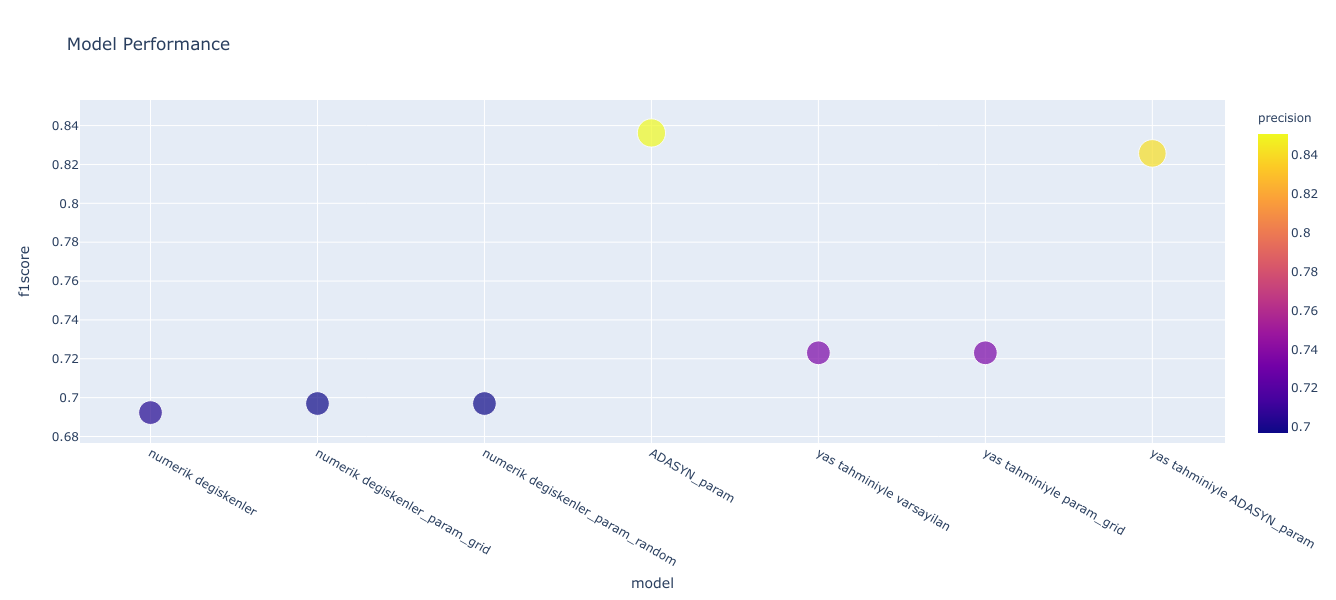

In [167]:
fig = px.scatter(performance_df, x='model', y='f1score', size='support_ratio',
                 color='precision', title='Model Performance', width=1200, height=600)
fig.show()